## Validation plots for HFS reconstruction

The first section here is to see how well the methods work if the Hadronic
Final State (HFS) that is within the detector acceptance is **perfectly** reconstructed.
That is, compute x,y,Q2 from HFS computed from gen-level particles within the detector
acceptance.

In [11]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os
import math

import uproot3

rc('text', usetex=True)

import matplotlib as mpl

mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 

ebeam_e = 27.6
ebeam_p = 920

infile_name = 'mini-tree.root'

### Read in the minitree root file into a pandas dataframe

In [12]:
ur_file = uproot3.open(infile_name)
print (ur_file.keys()) 
ur_tree = ur_file['minitree']
print(ur_tree)
mc   =  ur_tree.pandas.df(['*'], entrystop=3e7,flatten=True)
mc

[b'minitree;1']
<TTree b'minitree' at 0x0001199adf40>


,Q2_e,Q2_sigma,Q2_esigma,Q2_da,gen_Q2,y_e,y_sigma,y_esigma,y_da,HFS_px,...,HFS_theta,HFS_gamma,gen_HFS_px,gen_HFS_py,gen_HFS_pz,gen_HFS_e,gen_HFS_pt,gen_HFS_eta,gen_HFS_phi,gen_HFS_theta
entry,,,,,,,,,,,,,,,,,,,,,
0,468.797363,446.056671,468.797363,493.576904,494.087463,0.068597,0.021113,0.022189,0.019365,21.946800,...,0.090049,0.097101,20.816854,5.618251,251.771866,252.739471,21.561684,3.152581,0.263609,0.085431
1,1894.759888,1839.243164,1894.759888,1972.203491,1961.159668,0.297868,0.276675,0.285026,0.269170,-8.184976,...,0.592415,0.746081,-8.367181,37.409016,56.227032,71.281891,38.333332,1.176201,1.790842,0.598379
2,276.638916,275.250427,276.638916,277.117676,275.729858,0.292298,0.288728,0.290185,0.291074,9.406549,...,0.328148,1.706938,9.544287,-9.342526,50.367287,66.613632,13.355756,2.037674,-0.774716,0.259202
3,238.202896,238.123535,238.202896,238.850800,247.360428,0.315208,0.314980,0.315085,0.313346,-12.571018,...,0.429318,1.866927,-11.257093,2.772157,27.606129,43.507908,11.593404,1.602180,2.900138,0.397592
4,338.968628,354.665100,338.968628,315.247253,321.091949,0.580202,0.598781,0.572280,0.609580,-10.682003,...,1.695203,2.504634,-9.727129,3.941707,1.751308,34.981186,10.495432,0.166099,2.756587,1.405456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82850,670.273315,696.540771,670.273315,645.013794,644.488586,-0.009858,0.028225,0.027160,0.028199,-11.539625,...,0.120161,0.124184,-11.519830,22.674932,213.442383,215.018112,25.433424,2.823981,2.040857,0.118599
82851,319.102203,311.246521,319.102203,319.882477,318.792084,0.366897,0.350918,0.359775,0.365349,8.577925,...,0.460656,1.911436,7.645090,10.463070,35.908726,56.173195,12.958520,1.743448,0.939779,0.346329
82852,1181.045532,1121.059570,1181.045532,1201.989502,1243.584961,0.401450,0.369423,0.389190,0.390836,20.893599,...,0.549502,1.346172,22.037275,12.984096,51.431351,71.781227,25.577887,1.448443,0.532431,0.461502


### Do all of the calculations and save results as columns in the dataframe

In [45]:
def calc_gen_vals_of_xyQ2_from_gen_HFS( df ):
    
    temp = df
    
    temp.eval( 'Sigma__gen_HFS = gen_HFS_e - gen_HFS_pz', inplace=True )
    temp.eval( 'T__gen_HFS = gen_HFS_pt', inplace=True )
    temp.eval( 'tan_gamma_over_2__gen_HFS = Sigma__gen_HFS / T__gen_HFS', inplace=True )
   


   #-- Sigma 
    
    temp.eval( 'y_sigma__gen_HFS = Sigma__gen_HFS / (Sigma__gen_HFS + gen_e_e*(1-cos(gen_e_theta)))', inplace=True )
    
    temp.eval( 'Q2_sigma__gen_HFS = (gen_e_e*sin(gen_e_theta)) * (gen_e_e*sin(gen_e_theta)) / (1-y_sigma__gen_HFS)', inplace=True )

    temp.eval( 'x_sigma__gen_HFS = Q2_sigma__gen_HFS / ( y_sigma__gen_HFS * gen_s)', inplace=True )
    
    temp.eval('yratio_sigma__gen_HFS = y_sigma__gen_HFS / gen_y', inplace=True )
    temp.eval('xratio_sigma__gen_HFS = x_sigma__gen_HFS / gen_x', inplace=True )
    temp.eval('Q2ratio_sigma__gen_HFS = Q2_sigma__gen_HFS / gen_Q2', inplace=True )  
    
    
   #-- DA
    temp['gen_e_tan_theta_over_2'] = np.tan(df['gen_e_theta']/2.)
    temp.eval( 'y_da__gen_HFS = tan_gamma_over_2__gen_HFS/(tan_gamma_over_2__gen_HFS + gen_e_tan_theta_over_2)', inplace=True)
    
    temp.eval( 'Q2_da__gen_HFS = 4 * %f * %f * (1./gen_e_tan_theta_over_2) / (tan_gamma_over_2__gen_HFS + gen_e_tan_theta_over_2)' % (ebeam_e, ebeam_e), inplace=True)  

    temp.eval( 'x_da__gen_HFS = Q2_da__gen_HFS / ( y_da__gen_HFS * gen_s )', inplace=True )

    temp.eval('yratio_da__gen_HFS = y_da__gen_HFS / gen_y', inplace=True )
    temp.eval('xratio_da__gen_HFS = x_da__gen_HFS / gen_x', inplace=True )
    temp.eval('Q2ratio_da__gen_HFS = Q2_da__gen_HFS / gen_Q2', inplace=True ) 

    
    
   #-- hadron
    temp.eval( 'y_h__gen_HFS = Sigma__gen_HFS / (2 * %f)' % ebeam_e, inplace=True )
    
    temp.eval( 'Q2_h__gen_HFS = T__gen_HFS * T__gen_HFS / (1 - y_h__gen_HFS)', inplace=True )
    
    temp.eval( 'x_h__gen_HFS = Q2_h__gen_HFS / ( y_h__gen_HFS * gen_s )', inplace=True )
    
    temp.eval('yratio_h__gen_HFS = y_h__gen_HFS / gen_y', inplace=True )
    temp.eval('xratio_h__gen_HFS = x_h__gen_HFS / gen_x', inplace=True )
    temp.eval('Q2ratio_h__gen_HFS = Q2_h__gen_HFS / gen_Q2', inplace=True ) 
    
    
    return temp
    
    

In [46]:
mc = calc_gen_vals_of_xyQ2_from_gen_HFS( mc )

### Sigma method : inspect a few events

In [54]:
mc[['gen_y','y_sigma__gen_HFS',   'gen_Q2','Q2_sigma__gen_HFS',  'gen_x', 'x_sigma__gen_HFS']]

,gen_y,y_sigma__gen_HFS,gen_Q2,Q2_sigma__gen_HFS,gen_x,x_sigma__gen_HFS
entry,,,,,,
0,0.018350,0.017544,494.087463,493.681610,0.265095,0.277060
1,0.273263,0.272878,1961.159668,1960.120605,0.070660,0.070723
2,0.294624,0.294408,275.729858,275.645477,0.009214,0.009218
3,0.288882,0.288308,247.360428,247.161041,0.008430,0.008440
4,0.602341,0.602202,321.091949,320.979340,0.005248,0.005248
...,...,...,...,...,...,...
82850,0.028990,0.028559,644.488586,644.202332,0.218882,0.222090
82851,0.367513,0.367258,318.792084,318.663727,0.008540,0.008543
82852,0.369755,0.369063,1243.584961,1242.219116,0.033113,0.033139


### Double Angle (da) method : inspect a few events

In [48]:
mc[['gen_y','y_da__gen_HFS',    'gen_Q2','Q2_da__gen_HFS',    'gen_x', 'x_da__gen_HFS']]

,gen_y,y_da__gen_HFS,gen_Q2,Q2_da__gen_HFS,gen_x,x_da__gen_HFS
entry,,,,,,
0,0.018350,0.017912,494.087463,494.308990,0.265095,0.271701
1,0.273263,0.269858,1961.159668,1970.347656,0.070660,0.071887
2,0.294624,0.303472,275.729858,272.271240,0.009214,0.008833
3,0.288882,0.316677,247.360428,237.692062,0.008430,0.007390
4,0.602341,0.619751,321.091949,307.034454,0.005248,0.004878
...,...,...,...,...,...,...
82850,0.028990,0.028103,644.488586,645.078491,0.218882,0.225996
82851,0.367513,0.388759,318.792084,308.083160,0.008540,0.007802
82852,0.369755,0.390332,1243.584961,1202.983521,0.033113,0.030344


### Hadron method : inspect a few events

In [55]:
mc[['gen_y','y_h__gen_HFS',    'gen_Q2','Q2_h__gen_HFS',    'gen_x', 'x_h__gen_HFS']]

,gen_y,y_h__gen_HFS,gen_Q2,Q2_h__gen_HFS,gen_x,x_h__gen_HFS
entry,,,,,,
0,0.018350,0.017529,494.087463,473.200958,0.265095,0.265784
1,0.273263,0.272733,1961.159668,2020.501831,0.070660,0.072940
2,0.294624,0.294318,275.729858,252.771332,0.009214,0.008456
3,0.288882,0.288076,247.360428,188.793961,0.008430,0.006452
4,0.602341,0.601991,321.091949,276.762482,0.005248,0.004526
...,...,...,...,...,...,...
82850,0.028990,0.028546,644.488586,665.866760,0.218882,0.229661
82851,0.367513,0.367110,318.792084,265.327667,0.008540,0.007116
82852,0.369755,0.368657,1243.584961,1036.248779,0.033113,0.027675


### Sigma method: 2D plots and plots of rec/gen for x,y,Q2

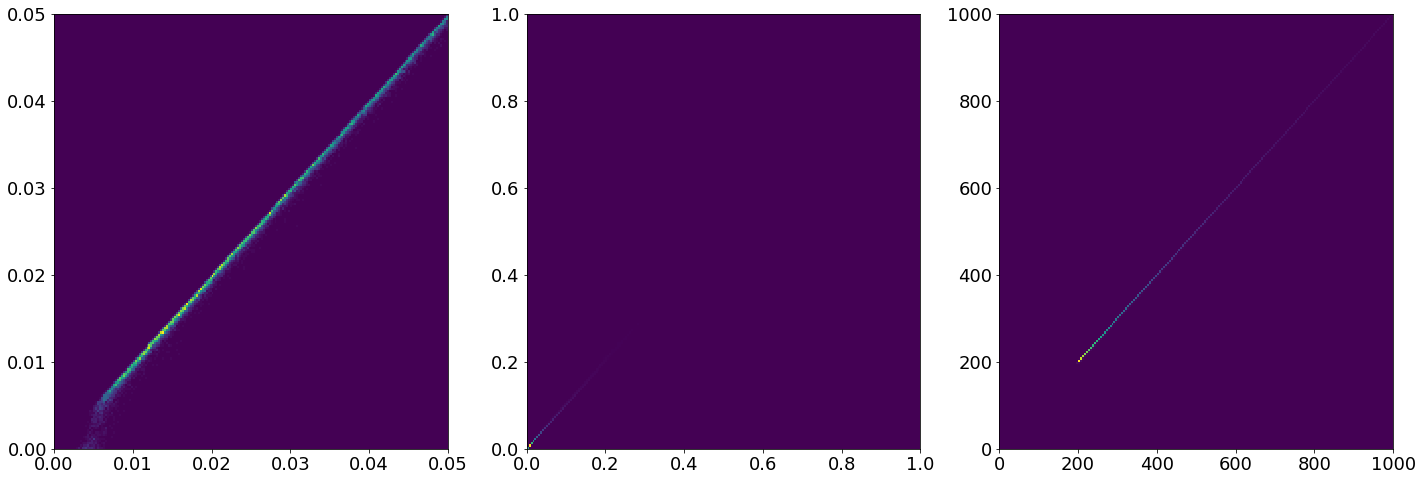

In [50]:
fig,ax = plt.subplots(1,3,figsize=(24,8))
ax = ax.flatten()
ax[0].hist2d(mc['gen_y'],mc['y_sigma__gen_HFS'], range = ([0,0.05],[0,0.05]), bins=200)
ax[1].hist2d(mc['gen_x'],mc['x_sigma__gen_HFS'], range = ([0,1],[0,1]), bins=200)
ax[2].hist2d(mc['gen_Q2'],mc['Q2_sigma__gen_HFS'], range = ([0,1000],[0,1000]), bins=200)
plt.show()

These look pretty good for the most part.  The agreement gets worse below y = 0.01.

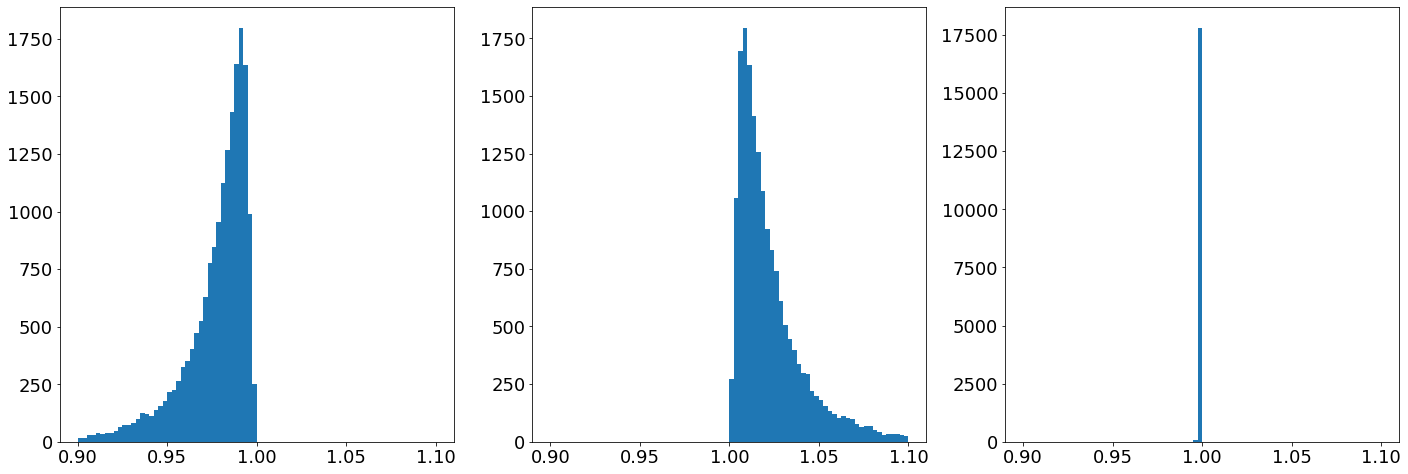

In [40]:


fig,ax = plt.subplots(1,3,figsize=(24,8))
ax = ax.flatten()
ax[0].hist(mc.query('gen_y>0.01 and gen_y<0.05')['yratio_sigma__gen_HFS'], range = (0.9,1.1), bins=80)
ax[1].hist(mc.query('gen_y>0.01 and gen_y<0.05')['xratio_sigma__gen_HFS'], range = (0.9,1.1), bins=80)
ax[2].hist(mc.query('gen_y>0.01 and gen_y<0.05')['Q2ratio_sigma__gen_HFS'], range = (0.9,1.1), bins=80)
plt.show()

This is far from perfect.  Looks like 3% error on y and x just from acceptance is not crazy.

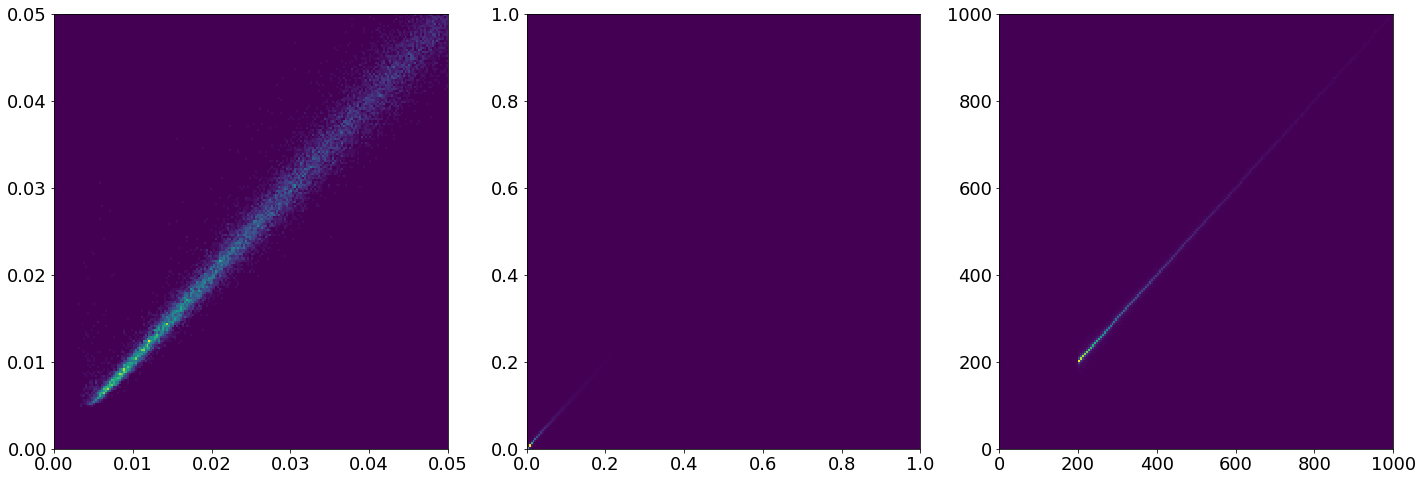

In [34]:
fig,ax = plt.subplots(1,3,figsize=(24,8))
ax = ax.flatten()
ax[0].hist2d(mc['gen_y'],mc['y_da__gen_HFS'], range = ([0,0.05],[0,0.05]), bins=200)
ax[1].hist2d(mc['gen_x'],mc['x_da__gen_HFS'], range = ([0,1],[0,1]), bins=200)
ax[2].hist2d(mc['gen_Q2'],mc['Q2_da__gen_HFS'], range = ([0,1000],[0,1000]), bins=200)
plt.show()

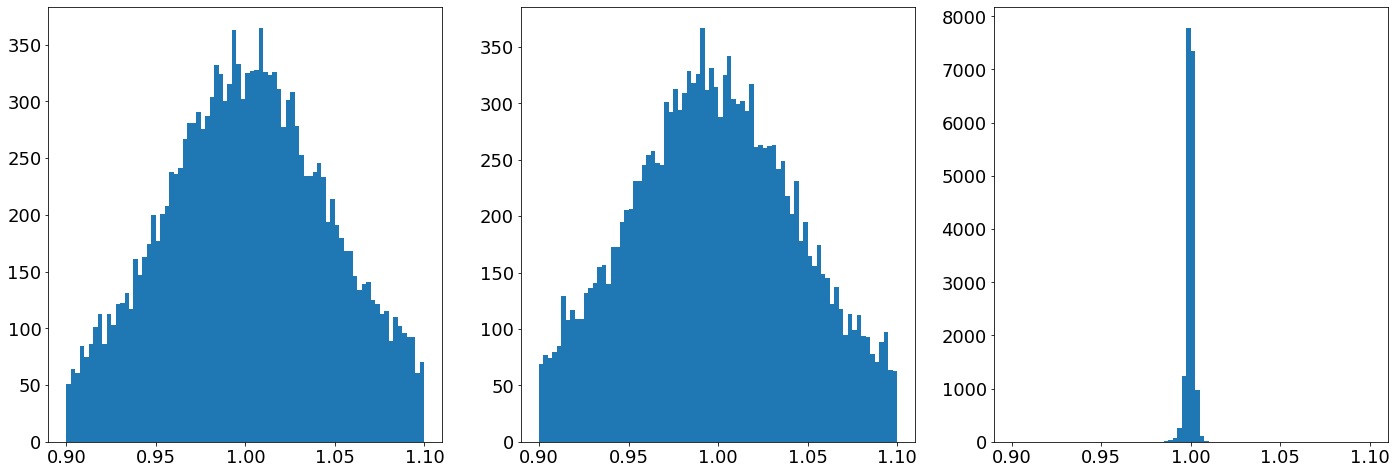

In [43]:
fig,ax = plt.subplots(1,3,figsize=(24,8))
ax = ax.flatten()
ax[0].hist(mc.query('gen_y>0.01 and gen_y<0.05')['yratio_da__gen_HFS'], range = (0.9,1.1), bins=80)
ax[1].hist(mc.query('gen_y>0.01 and gen_y<0.05')['xratio_da__gen_HFS'], range = (0.9,1.1), bins=80)
ax[2].hist(mc.query('gen_y>0.01 and gen_y<0.05')['Q2ratio_da__gen_HFS'], range = (0.9,1.1), bins=80)
plt.show()

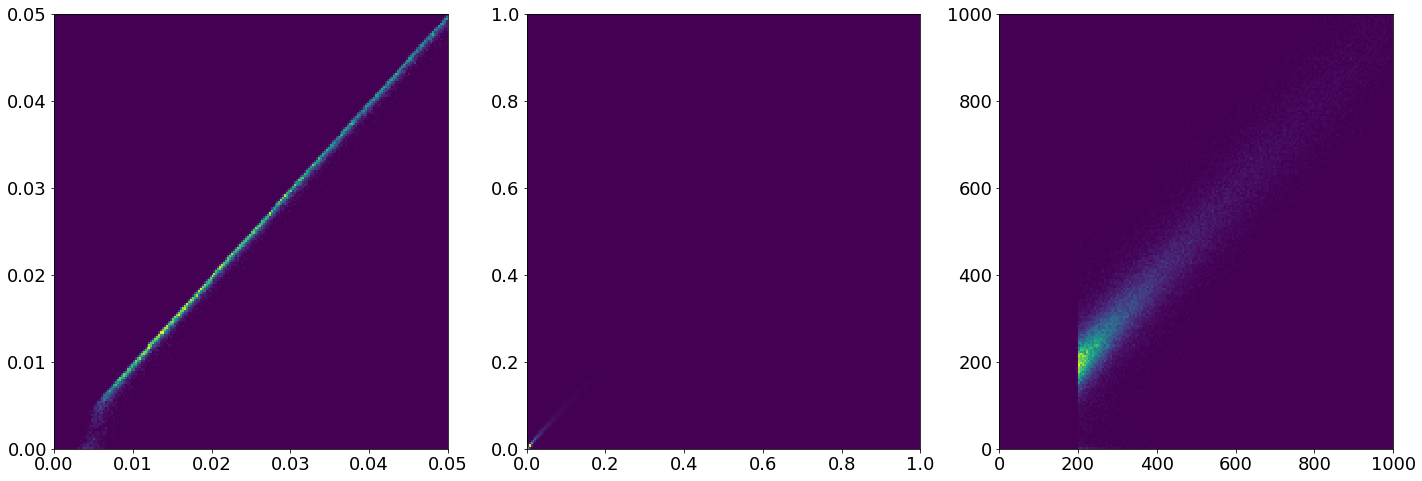

In [51]:
fig,ax = plt.subplots(1,3,figsize=(24,8))
ax = ax.flatten()
ax[0].hist2d(mc['gen_y'],mc['y_h__gen_HFS'], range = ([0,0.05],[0,0.05]), bins=200)
ax[1].hist2d(mc['gen_x'],mc['x_h__gen_HFS'], range = ([0,1],[0,1]), bins=200)
ax[2].hist2d(mc['gen_Q2'],mc['Q2_h__gen_HFS'], range = ([0,1000],[0,1000]), bins=200)
plt.show()

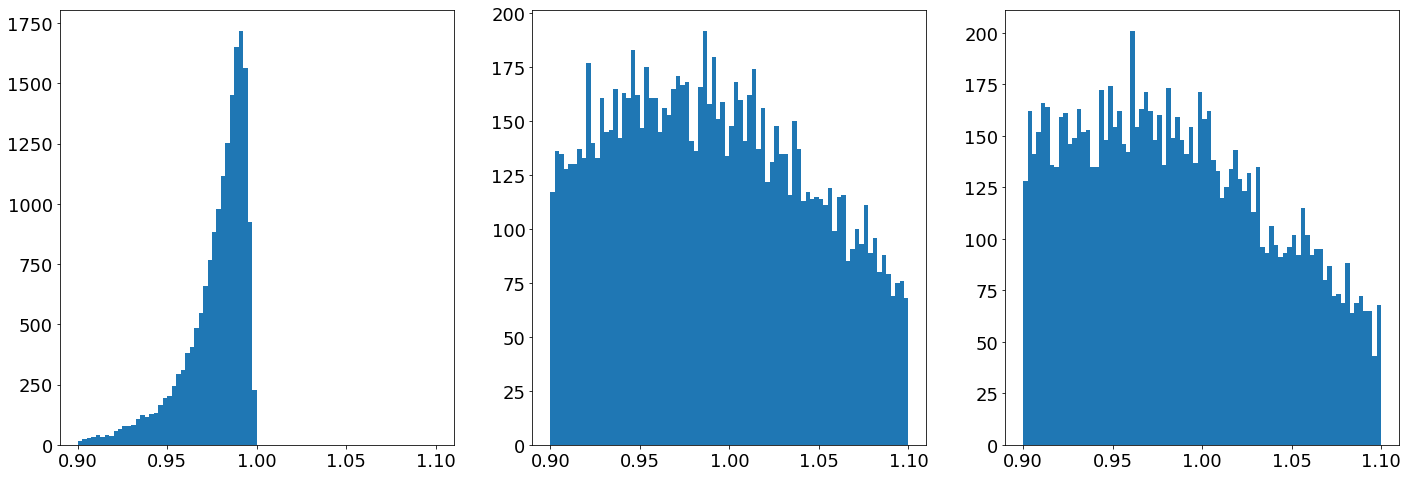

In [52]:
fig,ax = plt.subplots(1,3,figsize=(24,8))
ax = ax.flatten()
ax[0].hist(mc.query('gen_y>0.01 and gen_y<0.05')['yratio_h__gen_HFS'], range = (0.9,1.1), bins=80)
ax[1].hist(mc.query('gen_y>0.01 and gen_y<0.05')['xratio_h__gen_HFS'], range = (0.9,1.1), bins=80)
ax[2].hist(mc.query('gen_y>0.01 and gen_y<0.05')['Q2ratio_h__gen_HFS'], range = (0.9,1.1), bins=80)
plt.show()